# Backpropagation
A 3-layer neural network implemented in low level pytorch (tensors and matrix math only, used over numpy for gpu utility).

In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# build the dataset (train, validation and test)
def load_MNIST(n_val=10000):
    train = MNIST(root=".", train=True, download=True)
    test = MNIST(root=".", train=False, download=True)

    # data preprocessing
    x_train, x_test = train.data / 255, test.data / 255
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)
    y_train = torch.nn.functional.one_hot(train.targets)
    y_test = torch.nn.functional.one_hot(test.targets)

    data_dict = {}
    data_dict["x_train"] = x_train[:-n_val]
    data_dict["y_train"] = y_train[:-n_val]
    data_dict["x_val"] = x_train[-n_val:]
    data_dict["y_val"] = y_train[-n_val:]
    data_dict["x_test"] = x_test
    data_dict["y_test"] = y_test
    return data_dict

In [4]:
# you can start with a small sample dataset by setting sample=True
data_dict = load_MNIST()
print("Train data shape:", data_dict["x_train"].shape)
print("Train labels shape:", data_dict["y_train"].shape)
print("Validation data shape:", data_dict["x_val"].shape)
print("Validation labels shape:", data_dict["y_val"].shape)
print("Test data shape:", data_dict["x_test"].shape)
print("Test labels shape:", data_dict["y_test"].shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Train data shape: torch.Size([50000, 784])
Train labels shape: torch.Size([50000, 10])
Validation data shape: torch.Size([10000, 784])
Validation labels shape: torch.Size([10000, 10])
Test data shape: torch.Size([10000, 784])
Test labels shape: torch.Size([10000, 10])


In [5]:
# check the data distribution
for i in range(10):
    print(i, ":", torch.sum(torch.argmax(data_dict["y_test"], dim=1) == i))

0 : tensor(980)
1 : tensor(1135)
2 : tensor(1032)
3 : tensor(1010)
4 : tensor(982)
5 : tensor(892)
6 : tensor(958)
7 : tensor(1028)
8 : tensor(974)
9 : tensor(1009)


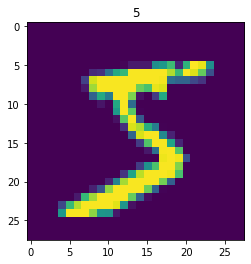

In [6]:
# plot an example
plt.imshow(data_dict["x_train"][0].reshape(28, 28))
plt.title(data_dict["y_train"][0].argmax().item())
plt.show()

In [7]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


def evaluator(test_y, pred_y):
    print("Confusion Matrix:\n", confusion_matrix(test_y, pred_y))
    print("\nPerformance Metrics:\n", classification_report(test_y, pred_y))
    print("\nAccuracy:", accuracy_score(test_y, pred_y))

## Model

In [8]:
class NN(object):
    def __init__(self, hidden_size, device, dtype=torch.float32):
        self.hidden_size = hidden_size
        self.device = device
        self.dtype = dtype
        self.history = {}
        self.history["train_acc"], self.history["val_acc"], self.history["loss"] = (
            [],
            [],
            [],
        )

    def sigmoid(self, x):
        # activation function
        return 1 / (1 + torch.exp(-x))

    def train(
        self,
        x,
        y,
        x_val,
        y_val,
        learning_rate=0.001,
        epochs=100,
        batch_size=200,
        verbose=0,
    ):
        n_train = x.shape[0]
        n_val = x_val.shape[0]
        input_size = x.shape[1]
        num_classes = y.shape[1]

        # init weights
        self.params = {}
        self.W1 = (
            torch.randn(
                input_size, self.hidden_size, dtype=self.dtype, device=self.device
            )
            * 0.01
        )
        self.b1 = torch.zeros(1, self.hidden_size, dtype=self.dtype, device=self.device)
        self.W2 = (
            torch.randn(
                self.hidden_size, num_classes, dtype=self.dtype, device=self.device
            )
            * 0.01
        )
        self.b2 = torch.zeros(1, num_classes, dtype=self.dtype, device=self.device)

        # training loop
        for epoch in range(epochs):
            loss = 0
            data = getBatch(x, y, batch_size)
            for x_batch, y_batch in data:
                # feedforward
                hid_a = x_batch @ self.W1 + self.b1
                hid_y = self.sigmoid(hid_a)

                out_a = hid_y @ self.W2 + self.b2
                out_y = self.sigmoid(out_a)

                # calculate error for each layer
                output_error = y_batch - out_y
                delta_out = output_error * (out_y * (1 - out_y))
                hidden_error = delta_out @ self.W2.t()

                # calculate loss (MSE)
                loss = torch.mean(output_error ** 2)

                # backward step (gradient descent)
                delta_hid = hidden_error * (hid_y * (1 - hid_y))

                delta_w2 = learning_rate * hid_y.t() @ delta_out
                delta_b2 = learning_rate * torch.sum(delta_out)
                delta_w1 = learning_rate * x_batch.t() @ delta_hid
                delta_b1 = learning_rate * torch.sum(delta_hid)

                self.W1 += delta_w1
                self.b1 += delta_b1
                self.W2 += delta_w2
                self.b2 += delta_b2

            # calculate epoch metrics
            y_pred = self.predict(x)
            train_acc = (
                torch.sum(torch.argmax(y, dim=1) == torch.argmax(y_pred, dim=1))
                / n_train
            )
            self.history["train_acc"].append(train_acc)
            self.history["loss"].append(loss)

            y_pred = self.predict(x_val)
            val_acc = (
                torch.sum(torch.argmax(y_val, dim=1) == torch.argmax(y_pred, dim=1))
                / n_val
            )
            self.history["val_acc"].append(val_acc)
            if verbose:
                print(
                    "epoch %d, loss %.4f, train acc %.3f, validation acc %.3f"
                    % (epoch + 1, loss, train_acc, val_acc)
                )

    def predict(self, x):
        # feedforward with learned weights
        hid_a = x @ self.W1 + self.b1
        hid_y = self.sigmoid(hid_a)

        out_a = hid_y @ self.W2 + self.b2
        out_y = self.sigmoid(out_a)

        return out_y


def getBatch(x, y, batch_size):
    n_epoch = x.shape[0] // batch_size
    for i in range(n_epoch):
        x_batch = x[i * batch_size : (i + 1) * batch_size]
        y_batch = y[i * batch_size : (i + 1) * batch_size]
        yield x_batch, y_batch
    x_batch = x[(i + 1) * batch_size :]
    y_batch = y[(i + 1) * batch_size :]
    yield x_batch, y_batch

In [9]:
# init model, tune hyperparameters, and train
hidden_size = 1000
model = NN(hidden_size, device)
model.train(
    data_dict["x_train"].to(device),
    data_dict["y_train"].to(device),
    data_dict["x_val"].to(device),
    data_dict["y_val"].to(device),
    learning_rate=0.04,
    epochs=50,
    batch_size=12,
    verbose=1,
)

epoch 1, loss 0.0237, train acc 0.886, validation acc 0.900
epoch 2, loss 0.0125, train acc 0.913, validation acc 0.922
epoch 3, loss 0.0089, train acc 0.928, validation acc 0.934
epoch 4, loss 0.0068, train acc 0.939, validation acc 0.946
epoch 5, loss 0.0053, train acc 0.947, validation acc 0.953
epoch 6, loss 0.0041, train acc 0.954, validation acc 0.957
epoch 7, loss 0.0034, train acc 0.959, validation acc 0.961
epoch 8, loss 0.0029, train acc 0.964, validation acc 0.965
epoch 9, loss 0.0026, train acc 0.968, validation acc 0.968
epoch 10, loss 0.0025, train acc 0.971, validation acc 0.970
epoch 11, loss 0.0024, train acc 0.974, validation acc 0.972
epoch 12, loss 0.0024, train acc 0.976, validation acc 0.972
epoch 13, loss 0.0023, train acc 0.978, validation acc 0.973
epoch 14, loss 0.0021, train acc 0.979, validation acc 0.974
epoch 15, loss 0.0019, train acc 0.981, validation acc 0.975
epoch 16, loss 0.0017, train acc 0.982, validation acc 0.976
epoch 17, loss 0.0015, train acc 

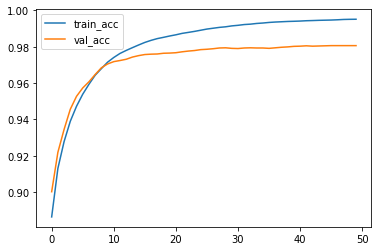

In [10]:
# plot model performance
try:
    plt.plot(model.history["train_acc"], label="train_acc")
    plt.plot(model.history["val_acc"], label="val_acc")
except TypeError:
    plt.plot([h.cpu() for h in model.history["train_acc"]], label="train_acc")
    plt.plot([h.cpu() for h in model.history["val_acc"]], label="val_acc")

plt.legend()
plt.show()

In [11]:
# evaluate model on test set
y_pred = model.predict(data_dict["x_test"].to(device))
evaluator(data_dict["y_test"].argmax(dim=1), torch.argmax(y_pred, dim=1).cpu())

Confusion Matrix:
 [[ 973    0    0    0    0    1    2    1    2    1]
 [   0 1124    3    2    0    1    2    0    3    0]
 [   3    3 1013    2    2    0    0    6    3    0]
 [   0    0    2  998    0    3    0    2    3    2]
 [   0    0    2    0  964    0    4    1    0   11]
 [   4    0    0   11    1  864    4    1    4    3]
 [   4    2    1    1    1    5  943    0    1    0]
 [   1    5    9    3    0    0    0  999    4    7]
 [   3    0    4    3    4    1    2    3  951    3]
 [   3    2    0    7    8    0    1    5    2  981]]

Performance Metrics:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98     